In [133]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import terrainutil
import matplotlib.animation as animation

In [2]:
def shine(x, s=1.):
    return s*np.arcsinh(x/s)

def uniform_poissonize(rs,mean,xsize,ppcell=1000.):
    """
    Monte-Carlo poissonization of the density field.
    """
    xpoisson = rs.poisson(size=xsize,lam=mean*ppcell).astype(float)/ppcell

    return xpoisson

def lum2feet(x):
    meters = 1500+2000*x
    feet = 3.28084*meters
    return feet

feetmin = lum2feet(0.)
feetmax = lum2feet(1.)

In [3]:
# Smooths out slopes of `terrain` that are too steep. Rough approximation of the
# phenomenon described here: https://en.wikipedia.org/wiki/Angle_of_repose
def apply_slippage(terrain, repose_slope, cell_width):
  delta = terrainutil.simple_gradient(terrain) / cell_width
  smoothed = terrainutil.gaussian_blur(terrain, sigma=1.5)
  should_smooth = np.abs(delta) > repose_slope
  result = np.select([np.abs(delta) > repose_slope], [smoothed], terrain)
  return result


In [230]:
def erode(terrain, velocity, sediment, water,
          cell_area = 200, rain_rate_mult = 0.0008, evaporation_rate = 0.0005, min_height_delta = 0.05, repose_slope = 0.03,
          gravity = 30.0, sediment_capacity_constant = 50.0, dissolving_rate = 0.25, deposition_rate = 0.001, seed=None, rs=None, random_rain='uniform'):
    # Add precipitation. This is done by via simple uniform random distribution,
    # although other models use a raindrop model
    rain_rate = cell_area*rain_rate_mult

    if (random_rain == 'poisson') or (random_rain == 'uniform'):
        if rs == None:
            rs = np.random.RandomState(seed=seed)
        if random_rain == 'poisson':
            water += uniform_poissonize(rs,rain_rate,np.prod(terrain.shape)).reshape(terrain.shape)
        elif random_rain =='uniform':
            water += np.random.rand(*shape) * rain_rate
    else:
        water += rain_rate
    
    # Compute the normalized gradient of the terrain height to determine where 
    # water and sediment will be moving.
    gradient = np.zeros_like(terrain, dtype='complex')
    gradient = terrainutil.simple_gradient(terrain)
    gradient = np.select([np.abs(gradient) < 1e-10],
                             [np.exp(2j * np.pi * np.random.rand(*shape))],
                             gradient)
    gradient /= np.abs(gradient)
    
    # Compute the difference between the current height the height offset by
    # `gradient`.
    neighbor_height = terrainutil.sample(terrain, -gradient)
    height_delta = terrain - neighbor_height
    
    # The sediment capacity represents how much sediment can be suspended in
    # water. If the sediment exceeds the quantity, then it is deposited,
    # otherwise terrain is eroded.
    sediment_capacity = (
        (np.maximum(height_delta, min_height_delta) / cell_width) * velocity *
        water * sediment_capacity_constant)
    deposited_sediment = np.select(
        [
          height_delta < 0, 
          sediment > sediment_capacity,
        ], [
          np.minimum(height_delta, sediment),
          deposition_rate * (sediment - sediment_capacity),
        ],
        # If sediment <= sediment_capacity
        dissolving_rate * (sediment - sediment_capacity))
    
    # Don't erode more sediment than the current terrain height.
    deposited_sediment = np.maximum(-height_delta, deposited_sediment)
    
    # Update terrain and sediment quantities.
    sediment -= deposited_sediment
    terrain += deposited_sediment
    sediment = terrainutil.displace(sediment, gradient)
    water = terrainutil.displace(water, gradient)
    
    # Smooth out steep slopes.
    terrain = apply_slippage(terrain, repose_slope, cell_width)
    
    # Update velocity
    velocity = gravity * height_delta / cell_width
    
    # Apply evaporation
    water *= 1 - evaporation_rate

    return terrain, velocity, sediment, water

In [315]:
# Grid dimension constants
full_width = 200
dim = 500
shape = [dim] * 2
cell_width = full_width / dim
cell_area = cell_width ** 2

# Water-related constants
rain_rate_mult = 0.0008
evaporation_rate = 0.0005

# Slope constants
min_height_delta = 0.05
repose_slope = 0.03
gravity = 30.0
gradient_sigma = 0.5

# Sediment constants
sediment_capacity_constant = 50.0
dissolving_rate = 0.25
deposition_rate = 0.001

# The numer of iterations is proportional to the grid dimension. This is to 
# allow changes on one side of the grid to affect the other side.
iterations = int(1.4 * dim)

# `terrain` represents the actual terrain height we're interested in
#terrain = terrainutil.fbm(shape, -2.0)

from PIL import Image
terrain = plt.imread("/Users/neyrinck/terra_software_class/terrain-erosion-3-ways/mountaincamp.png")[:,:,0]

# `sediment` is the amount of suspended "dirt" in the water. Terrain will be
# transfered to/from sediment depending on a number of different factors.
sediment = np.zeros_like(terrain)

# The amount of water. Responsible for carrying sediment.
water = np.zeros_like(terrain)

# The water velocity.
velocity = np.zeros_like(terrain)

terrain0 = 1.*terrain
velocity0 = 1.*velocity
sediment0 = 1.*sediment
water0 = 1.*water
for i in range(0):
    terrain, velocity, sediment, water = erode(terrain, velocity, sediment, water,
                                           cell_area = cell_area, rain_rate_mult = 2*rain_rate_mult, evaporation_rate = 5*evaporation_rate, 
                                           min_height_delta = min_height_delta, repose_slope = 2*repose_slope, gravity = gravity,
                                           sediment_capacity_constant = 0*sediment_capacity_constant, dissolving_rate = 0*dissolving_rate,
                                           deposition_rate = 0*deposition_rate, random_rain = None)

cmap = mpl.colormaps['terrain']



Axes(0.125,0.11;0.775x0.77)


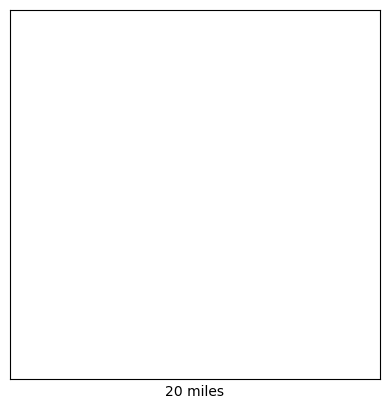

In [316]:
fig, ax = plt.subplots(nrows=1,ncols=1)
print(ax)

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ims = []
rs = np.random.RandomState()

for i in range(800):
    #rain_random = rs.gamma(2,scale=1)
    rain_random = rs.poisson(lam=0.2)**4
    terrain, velocity, sediment, water = erode(terrain, velocity, sediment, water,
                                           cell_area = cell_area, rain_rate_mult = rain_random*rain_rate_mult, evaporation_rate = evaporation_rate, 
                                           min_height_delta = min_height_delta, repose_slope = 10*repose_slope, gravity = gravity,
                                           sediment_capacity_constant = 0.5*sediment_capacity_constant, dissolving_rate = 0.5*dissolving_rate,
                                           deposition_rate = 0.5*deposition_rate, random_rain = None)

    plotter = terrain*(water <= 0.01) + 0 *(water > 0.01)
    #wherewater = np.where(water > 0.01)

    if (i % 2 == 0):    
        im = ax.imshow(lum2feet(plotter),vmin = feetmin,vmax=feetmax,cmap=cmap, animated=True)#; ax.colorbar()
        #im = ax.imshow(np.clip(water,0,0.1),vmin=0,vmax=0.4,alpha=5*np.clip(water,0,0.1))
        ax.set_xlabel('20 miles'); ax.set_xticks([]); ax.set_yticks([])
        ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()

In [317]:
print(ims)
ani.save('test.mp4')

[[<matplotlib.image.AxesImage object at 0x124313be0>], [<matplotlib.image.AxesImage object at 0x13ef96670>], [<matplotlib.image.AxesImage object at 0x13ef96b80>], [<matplotlib.image.AxesImage object at 0x13ec971f0>], [<matplotlib.image.AxesImage object at 0x13ec97dc0>], [<matplotlib.image.AxesImage object at 0x13ec97490>], [<matplotlib.image.AxesImage object at 0x13ecd9bb0>], [<matplotlib.image.AxesImage object at 0x13ebecd60>], [<matplotlib.image.AxesImage object at 0x13ebec190>], [<matplotlib.image.AxesImage object at 0x13ebec550>], [<matplotlib.image.AxesImage object at 0x13ec908e0>], [<matplotlib.image.AxesImage object at 0x13ec90550>], [<matplotlib.image.AxesImage object at 0x13ec907c0>], [<matplotlib.image.AxesImage object at 0x13ec90070>], [<matplotlib.image.AxesImage object at 0x13ec906d0>], [<matplotlib.image.AxesImage object at 0x13ece96d0>], [<matplotlib.image.AxesImage object at 0x13ece9970>], [<matplotlib.image.AxesImage object at 0x13ece9b20>], [<matplotlib.image.AxesImag